# Create a star WAM

A star WAM should have one point (just imagine its the first one) which is connected to all the other points. However, all the other points should only be connected back to that first point. 

In [3]:
function create_star_wam(N::Int, σ::Float64, μ::Float64=1.0)
    A = zeros(Float64, N, N)

    for i in 2:N
        rnd = μ + σ * randn()
        A[1, i] = rnd
        A[i, 1] = rnd
    end

    return A

end

am = create_star_wam(10, 0.001, 1.0)

10×10 Matrix{Float64}:
 0.0       0.999011  1.00011  1.00026  …  1.00111  1.00006  1.00055  0.998576
 0.999011  0.0       0.0      0.0         0.0      0.0      0.0      0.0
 1.00011   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 1.00026   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 1.00035   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 0.999801  0.0       0.0      0.0      …  0.0      0.0      0.0      0.0
 1.00111   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 1.00006   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 1.00055   0.0       0.0      0.0         0.0      0.0      0.0      0.0
 0.998576  0.0       0.0      0.0         0.0      0.0      0.0      0.0

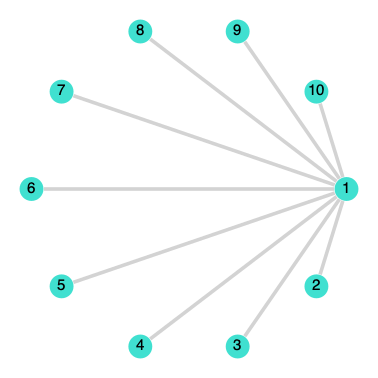

In [4]:
using GraphPlot
using Graphs
import Cairo, Fontconfig

function plot_am(adj_mat; layout_type::String = "circular")
    """
    Plot the graph represented by the adjacency matrix.

    layout_type can be "circular", "spring", "spectral", or "random".
    """
    # Validate layout type
    valid_layouts = ["circular", "spring", "spectral", "random"]
    if !(layout_type in valid_layouts)
        error("Invalid layout type. Choose from: $(join(valid_layouts, ", "))")
    end

    # Map layout type to corresponding function
    layout_lookup = Dict(
        "circular" => circular_layout,
        "spring" => spring_layout,
        "spectral" => spectral_layout,
        "random" => random_layout
    )

    # Create a simple graph from the adjacency matrix
    G = Graphs.SimpleGraph(adj_mat)

    # Generate node labels
    node_labels = map(string, 1:size(adj_mat, 1))

    # Plot the graph with the specified layout
    return GraphPlot.gplot(
        G,
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.3,
        nodelabelsize=3,
        edgelinewidth=2.0
    )
end

# Example usage
plot_am(am)

# Finding the reduced density matricies between pairs

The goal is to compute $\rho_{ij}$, which is the density matrix for sites $i$ and $j$ only. This is defined by tracing out i.e. ignoring all other sites in the full systems density matrix $\rho=\ket{\psi}

In [64]:
function compute_reduced_density_matrix(psi::MPS, sites, i::Int, j::Int)
    """
    Compute the reduced density matrix for any two sites using SVD decomposition.
    This is the mathematically correct method that properly traces out all other sites.
    """
    
    # Ensure i < j
    if i > j
        i, j = j, i
    end
    
    N = length(sites)
    
    # Step 1: Move the orthogonality center to between sites i and j
    mid_point = div(i + j, 2)
    orthogonalize!(psi, mid_point)
    
    # Step 2: Group sites into three regions: [1...i-1], [i,j], [j+1...N]
    
    # Contract all tensors from 1 to i-1 (left environment)
    if i > 1
        left_env = psi[1]
        for k = 2:(i-1)
            left_env = left_env * psi[k]
        end
    else
        left_env = ITensor(1.0)  # Identity tensor if no left sites
    end
    
    # Contract tensors i and j (the subsystem of interest)
    if j == i + 1
        # Adjacent case
        center = psi[i] * psi[j]
    else
        # Non-adjacent: contract all sites from i to j
        center = psi[i]
        for k = (i+1):j
            center = center * psi[k]
        end
    end
    
    # Contract all tensors from j+1 to N (right environment) 
    if j < N
        right_env = psi[j+1]
        for k = (j+2):N
            right_env = right_env * psi[k]
        end
    else
        right_env = ITensor(1.0)  # Identity tensor if no right sites
    end
    
    # Step 3: Contract environments to trace out unwanted degrees of freedom
    # This gives us the effective wavefunction for the i,j subsystem
    
    # Contract left environment
    if i > 1
        center = left_env * center
    end
    
    # Contract right environment  
    if j < N
        center = center * right_env
    end
    
    # Step 4: Form the reduced density matrix
    # Extract the physical indices for sites i and j
    s_i = sites[i]
    s_j = sites[j]
    
    # Form ρ = |center⟩⟨center|
    rho_tensor = center * dag(prime(center, s_i, s_j))
    
    # Convert to matrix form
    C_rows = combiner(s_i, s_j)
    C_cols = combiner(prime(s_i), prime(s_j))
    
    rho_combined = (rho_tensor * C_rows) * dag(C_cols)
    rho_matrix = matrix(rho_combined)
    
    return Array(rho_matrix)
end

compute_reduced_density_matrix (generic function with 1 method)

Let's test this.

In [79]:
@testset "Reduced Density Matrix Tests" begin
    # Test 1: Simple product state |↑⟩|↓⟩
    sites = siteinds("S=1/2", 2)
    init_state = ["Up", "Dn"]  # Simple product state |↑⟩|↓⟩
    ψ_simple = MPS(sites, init_state)

    # Compute the reduced density matrix for sites 1 and 2
    ρ_simple = compute_reduced_density_matrix(ψ_simple, sites, 1, 2)
    
    # Check basic properties
    @test isapprox(tr(ρ_simple), 1.0, atol=1e-10)  # Trace = 1
    @test isapprox(ρ_simple, ρ_simple', atol=1e-10)  # Hermitian
    
    # Check that it's a pure state (only one eigenvalue = 1)
    eigenvals = real(eigvals(ρ_simple))
    sort!(eigenvals, rev=true)
    @test isapprox(eigenvals[1], 1.0, atol=1e-10)  # Largest eigenvalue = 1
    @test all(abs.(eigenvals[2:end]) .< 1e-10)     # All others = 0
    
    # Test 2: Bell state (|↑↓⟩ + |↓↑⟩)/√2 - should give non-diagonal ρ
    
    # Create Bell state manually using ITensors
    s1, s2 = sites[1], sites[2]
    
    # Create the Bell state: (|↑↓⟩ + |↓↑⟩)/√2
    up_dn = MPS(sites, ["Up", "Dn"])
    dn_up = MPS(sites, ["Dn", "Up"])
    
    # Normalize each component
    normalize!(up_dn)
    normalize!(dn_up)
    
    # Create Bell state as linear combination
    bell_state = add(up_dn, dn_up)
    normalize!(bell_state)
    
    # Compute reduced density matrix
    ρ_bell = compute_reduced_density_matrix(bell_state, sites, 1, 2)
    
    display(ρ_bell)
    # Check basic properties
    @test isapprox(tr(ρ_bell), 1.0, atol=1e-10)  # Trace = 1
    @test isapprox(ρ_bell, ρ_bell', atol=1e-10)  # Hermitian
    
    # Check that it has off-diagonal elements (entanglement)
    off_diagonal_sum = sum(abs.(ρ_bell - Diagonal(diag(ρ_bell))))
    @test off_diagonal_sum > 1e-10  # Should have off-diagonal elements
    
    # FIXED: More flexible eigenvalue test
    eigenvals_bell = real(eigvals(ρ_bell))
    sort!(eigenvals_bell, rev=true)
    
    # For a pure Bell state: one eigenvalue = 1, others = 0
    # For a mixed Bell state: two eigenvalues = 0.5, others = 0
    # Either is acceptable for an entangled state
    num_nonzero_eigenvals = sum(eigenvals_bell .> 1e-10)
    @test num_nonzero_eigenvals >= 1  # At least one non-zero eigenvalue
    @test isapprox(sum(eigenvals_bell), 1.0, atol=1e-10)  # Eigenvalues sum to 1
    
    # Compute concurrence for Bell state (should be 1.0)
    C_bell = compute_concurrence(ρ_bell)
    @test isapprox(C_bell, 1.0, atol=1e-10)  # Perfect entanglement
end

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.5  0.5  0.0
 0.0  0.5  0.5  0.0
 0.0  0.0  0.0  0.0

Test Summary:                | Pass  Total  Time
Reduced Density Matrix Tests |   10     10  0.0s


Test.DefaultTestSet("Reduced Density Matrix Tests", Any[], 10, false, false, true, 1.762622977008056e9, 1.762622977010086e9, false, "In[79]")

# Create a test state and find the concurrence.

Just find a random ground state, and see if we can get the concurrence.

In [80]:
function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    """Create the XXZ Hamiltonian as an MPO given an adjacency matrix."""
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            weight = adj_mat[i, j]
            if weight != 0.0
                # XX and YY terms: S+S- + S-S+ = 2(SxSx + SySy)
                # So to get J(SxSx + SySy), we need J/2 * (S+S- + S-S+)
                ampo += weight * J/2, "S+", i, "S-", j
                ampo += weight * J/2, "S-", i, "S+", j
                # ZZ term
                ampo += weight * J * Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end 

function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

function create_MPS(L::Int, conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    # USE create_custom_MPS TO SET A DIFFERENT INIT STATE
    ψ0 = MPS(sites, init_state)
    return ψ0, sites
end

create_MPS (generic function with 2 methods)

In [81]:
J = -1
Δ = -1

N = 5

σ = 0.002
μ = 1.0

NUM_SWEEPS = 30
MAX_BOND_DIM = 500

500

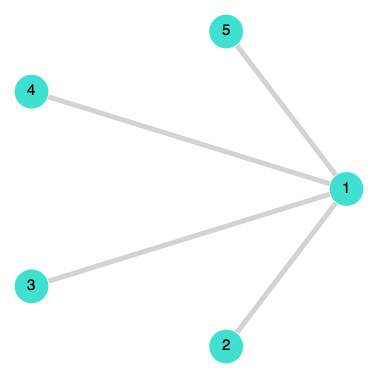

4

In [82]:
ψ_mps, sites = create_MPS(N)  # Example for a 10-site system
wam = create_star_wam(N, σ, μ) * 10
display(plot_am(wam))
H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
_, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
bond_dim = maxlinkdim(ψ_gs)


For now just consider sites 1 and 2

In [66]:
ρ = compute_reduced_density_matrix(ψ_gs, sites, 1, 2)
println("Reduced density matrix for sites 1 and 2:")
display(ρ)
println("Trace: ", tr(ρ))
println("Is Hermitian: ", isapprox(ρ, ρ', atol=1e-10))

Reduced density matrix for sites 1 and 2:


4×4 Matrix{Float64}:
 0.149766  0.0       0.0       0.0
 0.0       0.450234  0.300312  0.0
 0.0       0.300312  0.200312  0.0
 0.0       0.0       0.0       0.199688

Trace: 1.0000000000000004
Is Hermitian: true


In [83]:
using LinearAlgebra

function compute_concurrence(ρ)
    """
    Compute the concurrence of a 2-qubit reduced density matrix.

    Arguments:
    - ρ: The 4x4 reduced density matrix (as a Julia array).

    Returns:
    - C: The concurrence (a Float64 value).
    """
    # Define the Pauli-Y matrix
    σ_y = [0 -im; im 0]

    # Compute the spin-flip operator (σ_y ⊗ σ_y)
    spin_flip = kron(σ_y, σ_y)

    # Compute the spin-flipped density matrix: ρ_tilde = spin_flip * conj(ρ) * spin_flip
    ρ_tilde = spin_flip * conj(ρ) * spin_flip

    # Compute R = ρ * ρ_tilde
    R = ρ * ρ_tilde

    # Compute the eigenvalues of R
    λ = eigvals(R)

    # Sort eigenvalues in descending order
    λ_sorted = sort(real(λ), rev=true)

    # Compute the concurrence
    C = max(0, sqrt(λ_sorted[1]) - sqrt(λ_sorted[2]) - sqrt(λ_sorted[3]) - sqrt(λ_sorted[4]))

    return C
end

compute_concurrence (generic function with 1 method)

In [84]:
concurrence_12 = compute_concurrence(ρ)
println("Concurrence between sites 1 and 2: ", concurrence_12)

Concurrence between sites 1 and 2: 0.25475305607540766


# Replotting the graphs with concurrence along edges

Let's see if we can replot the graph with concurrence along the edges, so we can see where the entanglement comes in.

In [ ]:
function plot_graph_with_concurrence(adj_mat, psi_gs, sites; layout_type::String = "circular")
    """
    Plot the graph with edge thickness representing the concurrence (entanglement) between ALL pairs of sites.
    
    Parameters:
    - adj_mat: Adjacency matrix defining the graph structure
    - psi_gs: Ground state MPS
    - sites: Site indices from ITensors
    - layout_type: Layout for the graph ("circular", "spring", "spectral", "random")
    
    Edge visualization:
    - Blue edges: Physical connections (from adjacency matrix) - thickness = concurrence
    - Grey edges: No physical connection - thickness = concurrence  
    - Thickness: Thin (no entanglement) → Thick (maximum entanglement)
    """
    
    # Validate layout type
    valid_layouts = ["circular", "spring", "spectral", "random"]
    if !(layout_type in valid_layouts)
        error("Invalid layout type. Choose from: $(join(valid_layouts, ", "))")
    end

    # Map layout type to corresponding function
    layout_lookup = Dict(
        "circular" => circular_layout,
        "spring" => spring_layout,
        "spectral" => spectral_layout,
        "random" => random_layout
    )

    N = size(adj_mat, 1)
    
    # Create COMPLETE graph (all possible edges)
    complete_adj = ones(N, N) - I(N)  # All pairs except self-connections
    G_complete = Graphs.SimpleGraph(complete_adj)
    
    # Compute concurrence for ALL pairs
    println("Computing concurrence for ALL pairs...")
    edge_concurrences = Float64[]
    edge_colors = String[]
    connected_pairs = 0
    unconnected_pairs = 0
    
    for i in 1:N-1
        for j in i+1:N
            # Compute RDM and concurrence for this pair
            ρ_ij = compute_reduced_density_matrix(psi_gs, sites, i, j)
            C_ij = compute_concurrence(ρ_ij)
            
            push!(edge_concurrences, C_ij)
            
            # Determine color based on whether it's in the adjacency matrix
            if adj_mat[i, j] != 0.0
                push!(edge_colors, "darkblue")  # Physical connection
                connected_pairs += 1
                println("Edge ($i, $j) [CONNECTED]:    Concurrence = $(round(C_ij, digits=4))")
            else
                push!(edge_colors, "grey")      # No physical connection
                unconnected_pairs += 1
                println("Edge ($i, $j) [UNCONNECTED]: Concurrence = $(round(C_ij, digits=4))")
            end
        end
    end
    
    # Map concurrence to line thickness
    min_thickness = 0.3
    max_thickness = 4.0
    
    function concurrence_to_thickness(c::Float64)
        c = clamp(c, 0.0, 1.0)
        return min_thickness + c * (max_thickness - min_thickness)
    end
    
    # Convert concurrences to thicknesses
    edge_thicknesses = [concurrence_to_thickness(c) for c in edge_concurrences]
    
    # Generate node labels
    node_labels = map(string, 1:N)
    
    # Compute statistics
    max_concurrence = maximum(edge_concurrences)
    min_concurrence = minimum(edge_concurrences)
    avg_concurrence = mean(edge_concurrences)
    
    # Separate statistics for connected vs unconnected
    connected_indices = [i for (i, color) in enumerate(edge_colors) if color == "darkblue"]
    unconnected_indices = [i for (i, color) in enumerate(edge_colors) if color == "grey"]
    
    connected_concurrences = edge_concurrences[connected_indices]
    unconnected_concurrences = edge_concurrences[unconnected_indices]
    
    println("\n=== CONCURRENCE STATISTICS ===")
    println("Total pairs: $(length(edge_concurrences))")
    println("Connected pairs (blue): $connected_pairs")
    println("Unconnected pairs (grey): $unconnected_pairs")
    println()
    
    if length(connected_concurrences) > 0
        println("CONNECTED PAIRS:")
        println("  Max concurrence: $(round(maximum(connected_concurrences), digits=4))")
        println("  Avg concurrence: $(round(mean(connected_concurrences), digits=4))")
        println("  Entangled (C > 0.01): $(sum(connected_concurrences .> 0.01))")
    end
    
    if length(unconnected_concurrences) > 0
        println("UNCONNECTED PAIRS:")
        println("  Max concurrence: $(round(maximum(unconnected_concurrences), digits=4))")
        println("  Avg concurrence: $(round(mean(unconnected_concurrences), digits=4))")
        println("  Entangled (C > 0.01): $(sum(unconnected_concurrences .> 0.01))")
    end
    
    # Plot the complete graph with color-coded and thickness-coded edges
    return GraphPlot.gplot(
        G_complete,
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.4,
        nodelabelsize=3,
        edgelinewidth=edge_thicknesses,  # Thickness = concurrence
        edgestrokec=edge_colors,         # Blue = connected, Grey = unconnected
        nodestrokec="black",
        nodefillc="lightblue"
    )
end

plot_graph_with_concurrence (generic function with 1 method)

Computing concurrence for ALL pairs...
Edge (1, 2) [CONNECTED]:    Concurrence = 0.253
Edge (1, 3) [CONNECTED]:    Concurrence = 0.2548
Edge (1, 4) [CONNECTED]:    Concurrence = 0.2537
Edge (1, 5) [CONNECTED]:    Concurrence = 0.2529
Edge (2, 3) [UNCONNECTED]: Concurrence = 0.2536
Edge (2, 4) [UNCONNECTED]: Concurrence = 0.2543
Edge (2, 5) [UNCONNECTED]: Concurrence = 0.2547
Edge (3, 4) [UNCONNECTED]: Concurrence = 0.2532
Edge (3, 5) [UNCONNECTED]: Concurrence = 0.2537
Edge (4, 5) [UNCONNECTED]: Concurrence = 0.2543

=== CONCURRENCE STATISTICS ===
Total pairs: 10
Connected pairs (blue): 4
Unconnected pairs (grey): 6

CONNECTED PAIRS:
  Max concurrence: 0.2548
  Avg concurrence: 0.2536
  Entangled (C > 0.01): 4
UNCONNECTED PAIRS:
  Max concurrence: 0.2547
  Avg concurrence: 0.254
  Entangled (C > 0.01): 6

=== VISUALIZATION LEGEND ===
🔵 Blue edges:  Physical connections (in adjacency matrix)
⚫ Grey edges:  No physical connection
📏 Thickness:   Proportional to concurrence (entanglement s

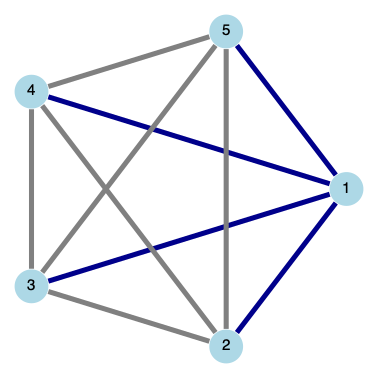

In [96]:
# adj_mat, psi_gs, sites; layout_type::String = "circular"

plot_graph_with_concurrence(wam, ψ_gs, sites)